# Evaluating Espresso Preparation Methods

The following notebook is intended to evaluate the different espresso preparation methods. The primary question that is being evaluated is which method reduces the variation in pull time, or how reproducible a method is. 

### Setup

* Machine: Linea Mini
* Grinder: Kafatek MC3
* Basket: VST 18g
* Ground Coffee In: 18g +/- 0.1g
* Liquid Coffee Out: 36g +/- 1g
* Tamper: Pullman Big Step
* Liquid Scale: Acaia Lunar
* Coffee Scale: Acaia Pearl

## Preparation Methods

For all methods coffee is ground into the portafilter, then if necessary a spoon is used to reduce the coffee to 18.0g. 

* No Prep
* RDT (Full depth)
  * Tool provided with Kafatek MC3
* WDT
  * One spritz from small spray bottle
* Double Tap
  * Tap portafilter twice on flat surface
* OCD
  * Setting used is consistent and set at lowest possible while getting a flat surface


## Collection Method

1. Weigh out 18.2+g of coffee
1. If WDT, spray beans and stir
1. Grind beans into portafilter, engage motor on MC3 prior to adding beans
1. Remove excess grounds, leaving 18.0g in portafilter
1. Perform prep method, tamp
1. Pull espresso shot, watching for channeling
1. Stop machine when 36g in the cup reached, record time (+/- 1 second accuracy)
1. Record work space temperature/humidity

In [1]:
import os

from collections import defaultdict
from tempfile import NamedTemporaryFile

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from astropy import stats as asp
from astropy.utils import NumpyRNGContext

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [2]:
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv&gid=1726376181"
plt.rcParams["figure.dpi"] = 150

In [3]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(" ", "")
    .str.replace("(", "")
    .str.replace(")", "")
)

## Impact of Temperature/Humdity

During my time spent hang around coffee shops, I have heard the ambient temperature/humidity blamed for espresso pull times being all over the place. The following graphs present the raw data, in case there is some relation that comes out. So far there is no obvious trend, despite fairly significant differences in time.

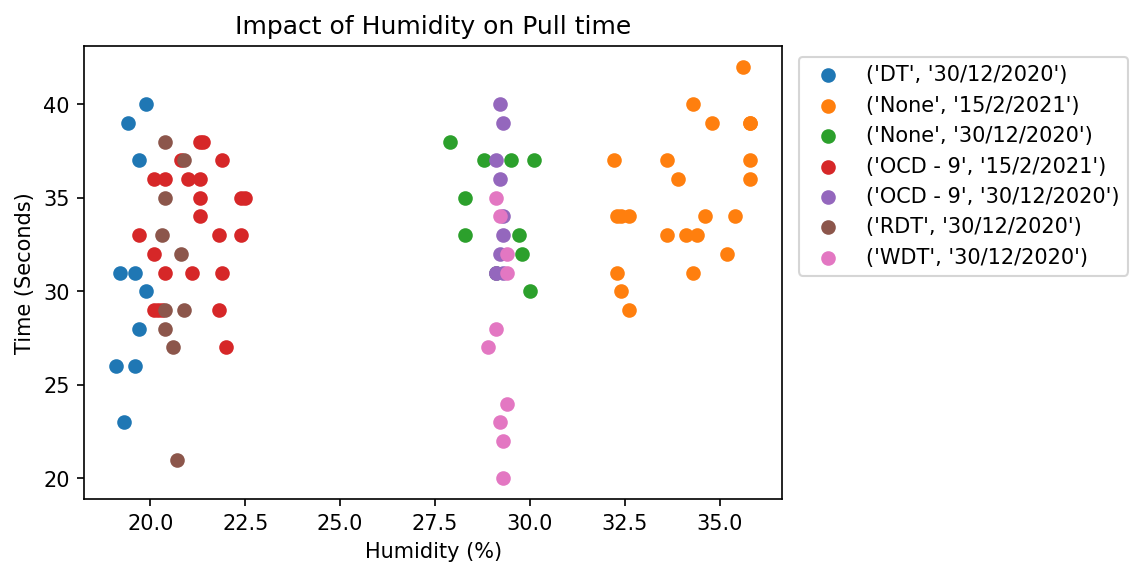

In [4]:
for name, subdf in df.groupby(["prepmethod", "roastdate"]):
    plt.scatter(subdf["humidity%"], subdf["timeseconds"], label=name)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
ax = plt.gca()
ax.set_title("Impact of Humidity on Pull time")
ax.set_ylabel("Time (Seconds)")
ax.set_xlabel("Humidity (%)")
plt.show()

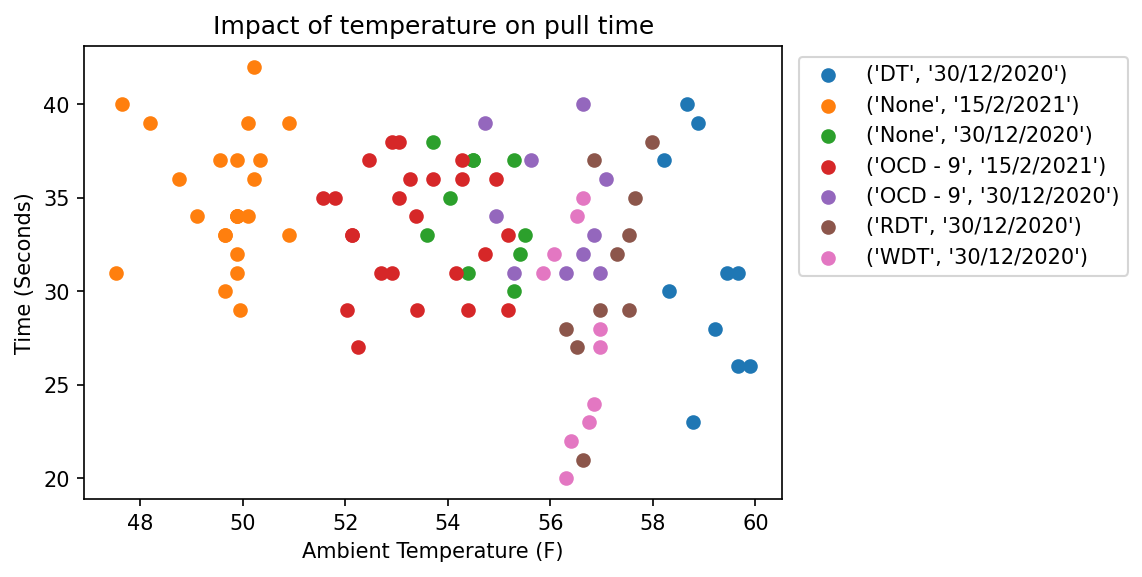

In [5]:
for name, subdf in df.groupby(["prepmethod", "roastdate"]):
    plt.scatter(subdf["tempf"], subdf["timeseconds"], label=name)
ax = plt.gca()
ax.set_title("Impact of temperature on pull time")
ax.set_ylabel("Time (Seconds)")
ax.set_xlabel("Ambient Temperature (F)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.show()

## Data Distribution

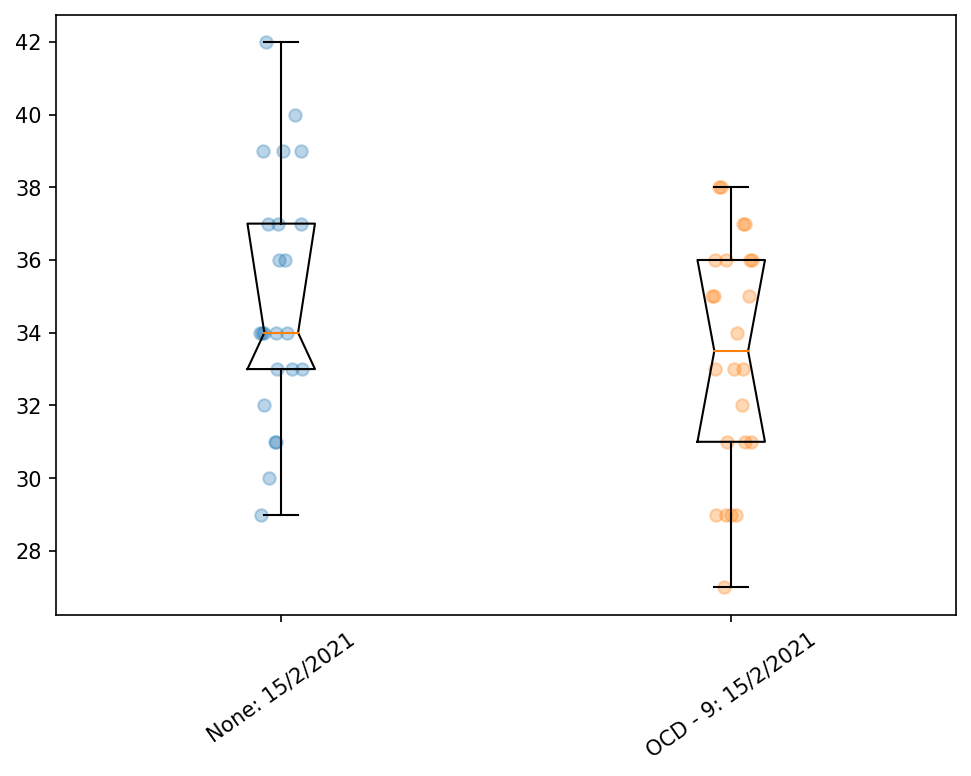

In [6]:
fig = plt.Figure()
axe = fig.add_axes([0, 0, 1, 1])

grouped = df.groupby(["prepmethod", "roastdate"])
columns = []
times = []

for i, (name, subdf) in enumerate(grouped):
    if len(subdf["timeseconds"]) <= 10:
        continue
    columns.append(f"{name[0]}: {name[1]}")
    times.append(subdf["timeseconds"].tolist())

axe.boxplot(times, labels=columns, notch=True, bootstrap=10000)
uni_range = 0.05
i = 0
for column, vals in zip(columns, times):
    center = i + 1
    axe.scatter(
        np.random.uniform(center - uni_range, center + uni_range, len(vals)),
        vals,
        alpha=0.3,
    )
    i += 1
axe.set_xticklabels(columns, rotation=35, ha="center")
display(fig)

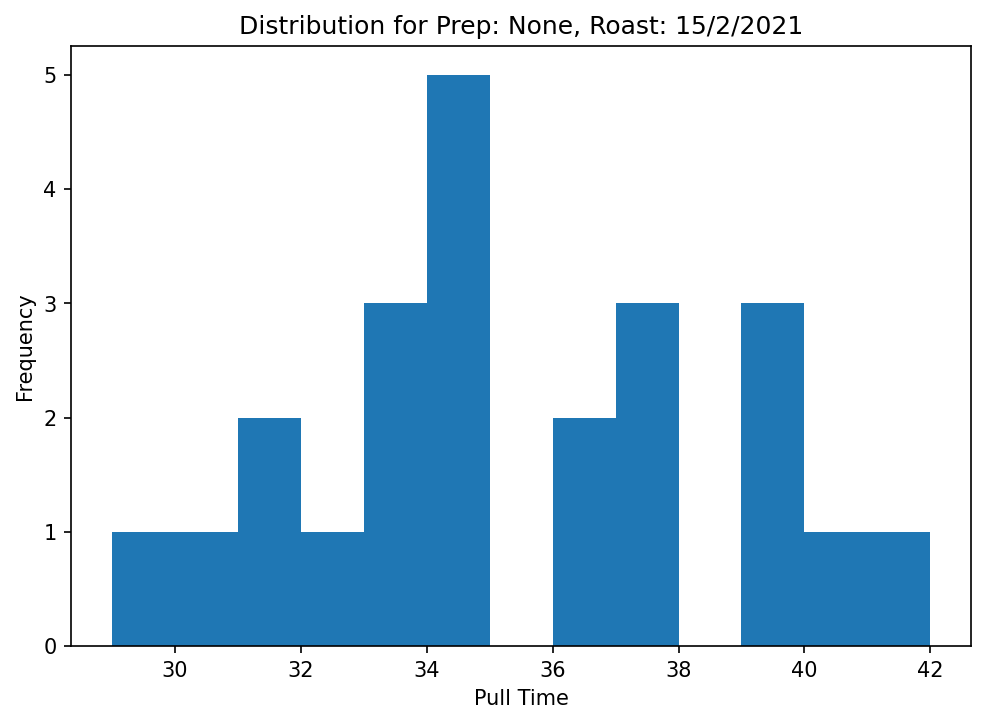

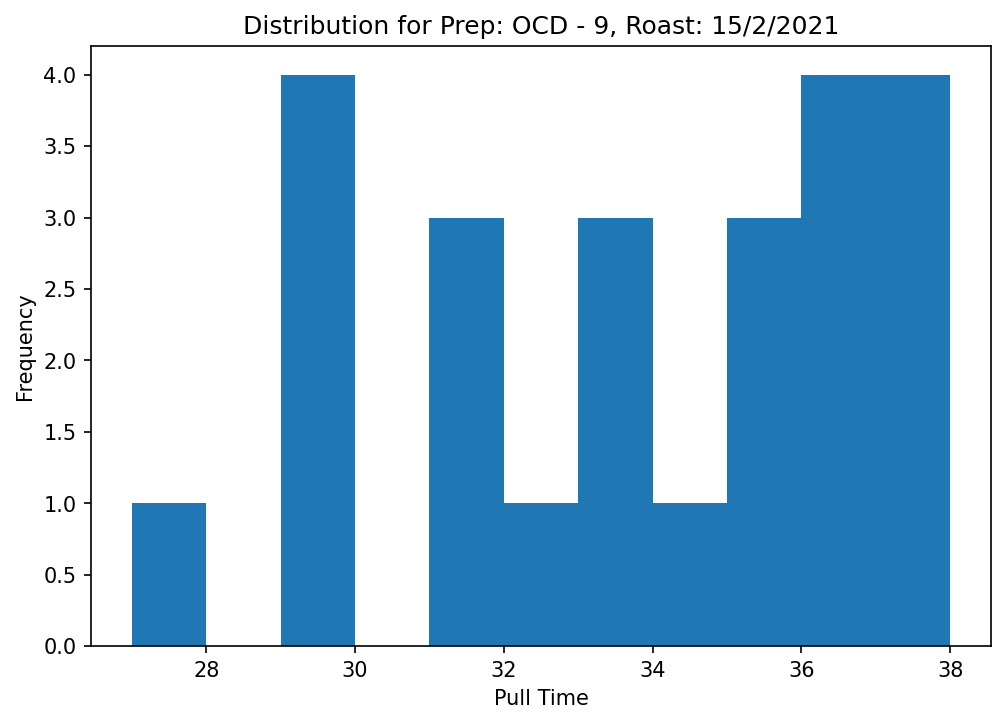

In [7]:
for method in df.prepmethod.unique():
    methdf = df[df.prepmethod == method]
    for roast in methdf.roastdate.unique():
        subdf = methdf[methdf.roastdate == roast]
        if len(subdf["timeseconds"]) <= 10:
            continue
        fig = plt.Figure()
        axe = fig.add_axes([0, 0, 1, 1])
        hist_data = []
        for val in subdf["timeseconds"]:
            hist_data.append(val)
        axe.hist(
            hist_data, int(subdf["timeseconds"].max() - subdf["timeseconds"].min())
        )
        axe.set_xlabel("Pull Time")
        axe.set_ylabel("Frequency")
        axe.set_title(f"Distribution for Prep: {method}, Roast: {roast}")
        display(fig)

In [8]:
# Anova test

# Unclear that it is Normal so far, can't use ANOVA
# anova_df = df.groupby(["roastdate", "prepmethod"])
# for name, subdf in anova_df:
#     for comp_name, compdf in anova_df:
#         if name == comp_name:
#             continue
#         f, p = stats.f_oneway(subdf.timeseconds.tolist(), compdf.timeseconds.tolist())
#         print(f"Comparing {name} to {comp_name}")
#         print("------")
#         print(f"F Statistic: {f}")
#         print(f"P Value: {p}")
#         print()

In [9]:
ks_df = df.groupby(["roastdate", "prepmethod"])
cutoff = 0.25
similar_dists = []
pairs = set()
for name, subdf in ks_df:
    if len(subdf["timeseconds"]) <= 10:
        continue
    for comp_name, compdf in ks_df:
        if name == comp_name:
            continue
        if len(compdf["timeseconds"]) <= 10:
            continue
        if (name, comp_name) in pairs or (comp_name, name) in pairs:
            continue
        # print("Two Distributions", name, comp_name)
        # "If the KS statistic is small or the p-value is high, then we cannot reject
        # the hypothesis that the distributions of the two samples are the same."
        # - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
        ktest = stats.ks_2samp(subdf.timeseconds, compdf.timeseconds)
        # print("Statistic", ktest.statistic, "P-Value", ktest.pvalue)
        if ktest.pvalue > cutoff:
            similar_dists.append((name, comp_name, [subdf, compdf], ktest))
        pairs.add((name, comp_name))
similar_dists.sort(key=lambda x: x[3].pvalue, reverse=True)
print("P Cutoff value", cutoff)
for name, comp_name, _, ktest in similar_dists:
    print(f"{name} and {comp_name} are potentially from the same distribution")
    print("Statistic", ktest.statistic, "P-Value", ktest.pvalue)
    print()

P Cutoff value 0.25
('15/2/2021', 'None') and ('15/2/2021', 'OCD - 9') are potentially from the same distribution
Statistic 0.21739130434782608 P-Value 0.5547385084394063



In [10]:
def permutation_test(xs, ys, func=np.median, nmc=20000):
    """Thanks to Paul Hawkins for this

    The null hypothesis is that the two samples are from the same distribution.
    """
    n = len(xs)
    k = 0
    difflist = []
    zs = np.concatenate([xs, ys])

    diff = func(xs) - func(ys)

    for _ in range(nmc):
        np.random.shuffle(zs)

        mdiff = func(zs[:n]) - func(zs[n:])
        difflist.append(mdiff)

        if mdiff >= diff:
            k += 1
        elif mdiff == diff:
            k += 0.5

    p_val = k / nmc

    return p_val, diff, difflist

In [11]:
# Test different measures of variance
for name, subdf in df.groupby(["roastdate", "prepmethod"]):
    if len(subdf["timeseconds"]) <= 10:
        continue
    print(name)
    print("-" * len(str(name)))
    print(
        "Normal Mean, Std:",
        round(np.mean(subdf.timeseconds), 3),
        round(np.std(subdf.timeseconds), 3),
    )
    with NumpyRNGContext(814):
        bootres = asp.bootstrap(subdf.timeseconds.values, 10000, bootfunc=np.median)
    print("Median, Std", np.median(subdf.timeseconds), bootres.std())
    print(
        "Trimmed Mean, Std:",
        round(stats.trim_mean(subdf.timeseconds, proportiontocut=0.1), 3),
        round(stats.mstats.trimmed_stde(subdf.timeseconds, (0.1, 0.1)), 3),
    )  # Trimmed mean and std at 10%
    with NumpyRNGContext(814):
        bootres = asp.bootstrap(
            subdf.timeseconds.values, 10000, bootfunc=asp.biweight_location
        )
    print(
        "Biweighted Mean, Std:",
        round(asp.biweight_location(subdf.timeseconds), 3),
        round(bootres.std(), 3),
    )
    winsored = stats.mstats.winsorize(subdf.timeseconds, limits=(0.05, 0.05))
    print(
        "Winsorized Mean, Std:", round(np.mean(winsored), 3), round(np.std(winsored), 3)
    )
    print()

('15/2/2021', 'None')
---------------------
Normal Mean, Std: 34.957 3.329
Median, Std 34.0 1.1053443988187572
Trimmed Mean, Std: 34.895 0.753
Biweighted Mean, Std: 34.776 0.841
Winsorized Mean, Std: 34.913 3.092

('15/2/2021', 'OCD - 9')
------------------------
Normal Mean, Std: 33.333 3.171
Median, Std 33.5 1.1445281462244605
Trimmed Mean, Std: 33.4 0.759
Biweighted Mean, Std: 33.446 0.898
Winsorized Mean, Std: 33.417 3.027



('15/2/2021', 'None') and ('15/2/2021', 'OCD - 9') permutation test, mean method: mean
P-Val 0.0545 Diff 1.6231884057971016


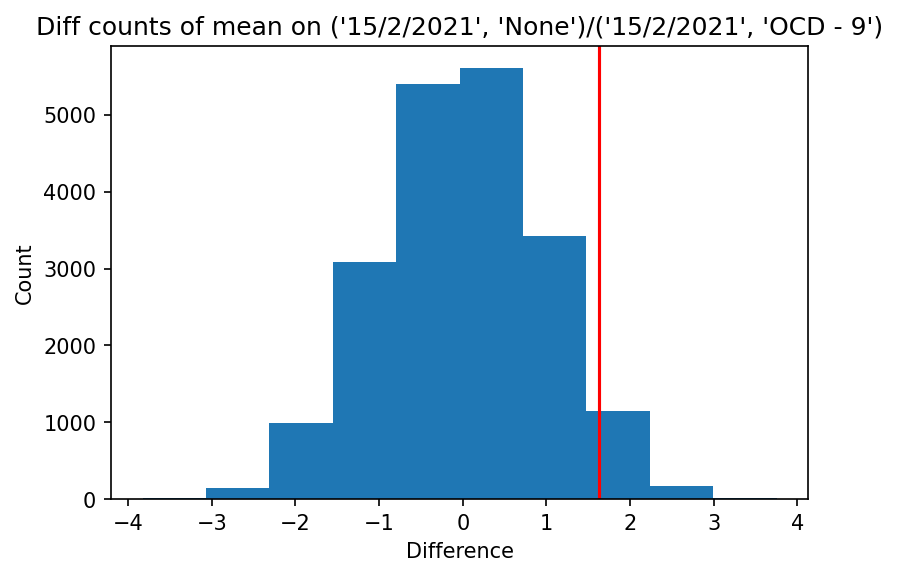

('15/2/2021', 'None') and ('15/2/2021', 'OCD - 9') permutation test, mean method: median
P-Val 0.3076 Diff 0.5


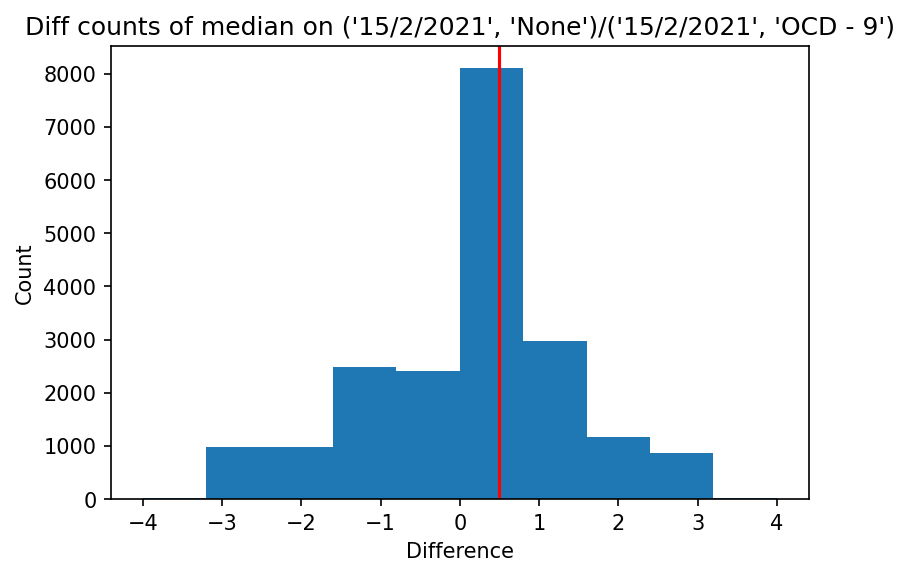

('15/2/2021', 'None') and ('15/2/2021', 'OCD - 9') permutation test, mean method: trimmed mean
P-Val 0.08345 Diff 1.4947368421052616


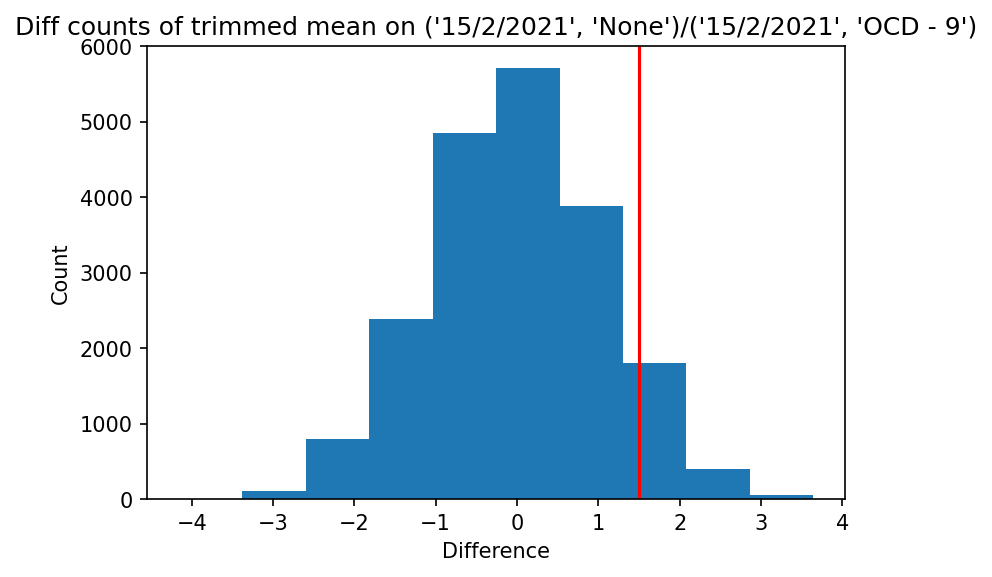

('15/2/2021', 'None') and ('15/2/2021', 'OCD - 9') permutation test, mean method: biweighted
P-Val 0.1179 Diff 1.3300777474312824


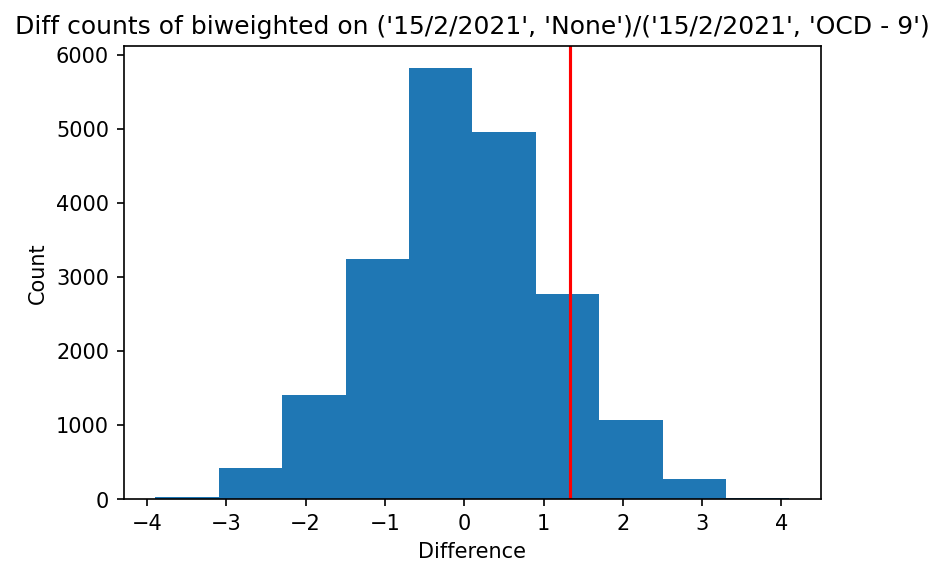

In [12]:
for name, comp_name, (subdf, compdf), _ in similar_dists:
    for mean_name, mean_meth in [
        ("mean", np.mean),
        ("median", np.median),
        ("trimmed mean", lambda x: stats.trim_mean(x, proportiontocut=0.1)),
        ("biweighted", asp.biweight_location),
    ]:
        print(f"{name} and {comp_name} permutation test, mean method: {mean_name}")
        p, diff, difflist = permutation_test(
            subdf.timeseconds.values, compdf.timeseconds.values, func=mean_meth
        )
        print("P-Val", p, "Diff", diff)
        plt.hist(difflist)
        plt.axvline(diff, color="red")
        ax = plt.gca()
        ax.set_title(f"Diff counts of {mean_name} on {name}/{comp_name}")
        ax.set_xlabel("Difference")
        ax.set_ylabel("Count")
        plt.show()